In [14]:
import pandas as pd
import numpy as np
import feature_engine 
import pickle
import matplotlib.pyplot as plt
import plotly.express as px


In [95]:
ENCODED_DATA_PATH = '../data/processed/1_encoded_df.pkl'
TARGET_COL = 'DevType'
CLUSTERED_DF_PATH = '../data/processed/1_clustered_skills_df.pkl'

In [3]:
df = pd.read_pickle(ENCODED_DATA_PATH)
df.head()

LanguageHaveWorkedWith                                                      \
                     APL Assembly Bash/Shell  C C# C++ COBOL Clojure Crystal   
0                      0        0          0  0  0   1     0       0       0   
1                      0        0          0  0  0   0     0       0       0   
2                      0        1          0  1  0   0     0       0       0   
3                      0        0          0  0  0   0     0       0       0   
4                      0        0          1  0  0   0     0       0       0   

        ...        DevType                                                 \
  Dart  ... Engineer, data Engineer, site reliability Engineering manager   
0    0  ...              0                          0                   0   
1    0  ...              0                          0                   0   
2    0  ...              0                          0                   0   
3    0  ...              0                          0                   0   
4    0  ...              1                          0                   0   

                                                                           \
  Marketing or sales professional Other (please specify): Product manager   
0                               0                       0               0   
1                               0                       0               0   
2                               0                       0               0   
3                               0                       0               0   
4                               0                       1               0   

                                                                               
  Scientist Senior Executive (C-Suite, VP, etc.) Student System administrator  
0         0                                    0       0                    0  
1         0                                    0       0                    0  
2         0                                    0       0                    0  
3         0                                    0       0                    0  
4         0                                    0       0                    0  

[5 rows x 150 columns]

### Skills Associations -> Clustering

In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
skill_groups = set([ group  for group,col in df.drop('DevType',axis=1).columns ])
skills_df = pd.concat([ df.loc[:,group]  for group in skill_groups ],axis=1)


In [16]:

tsne = TSNE(n_components=2,
                       perplexity=3,
                       learning_rate=0.01,
                       init='pca', 
                       method='barnes_hut', 
                       n_jobs=-1, 
                       n_iter=10**10,
                        random_state=42)
reduced_data = tsne.fit_transform(skills_df.T)


c:\Users\Abdelhakiem\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [22]:
reduced_data = pd.DataFrame(reduced_data, index=skills_df.columns)
reduced_data

,0,1
Cassandra,0.503655,-2.268087
Couchbase,2.802016,-3.386829
DynamoDB,7.568566,-9.652098
Elasticsearch,3.935895,-14.168550
Firebase,-23.922806,1.010241
...,...,...
Vim,-10.665123,-5.848335
Visual Studio,11.550916,29.808064
Visual Studio Code,29.907810,7.617950
Webstorm,4.146099,1.499286


In [28]:
fig = px.scatter(x=reduced_data.iloc[:, 0],
                 y=reduced_data.iloc[:, 1],
                 text=reduced_data.index.to_list())
fig.update_layout(
    title="t-SNE visualization of Skills",
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE",
)
fig.show()

We observe that skills can be clustered. We can reduce number of features by grouping skills together.

But what is the suitable number of clusters?

In [38]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
plt.figure(figsize=(6, 5))
n_clusters = range(10, 27)
scores=[]
best_clustering_model = None
for i in n_clusters:
    agg_clust = AgglomerativeClustering(n_clusters=i, linkage='ward')
    labels = agg_clust.fit_predict(reduced_data)
    score = silhouette_score(reduced_data, labels)
    scores.append(score)
    if score >= np.max(scores) :
        best_clustering_model = agg_clust

<Figure size 600x500 with 0 Axes>

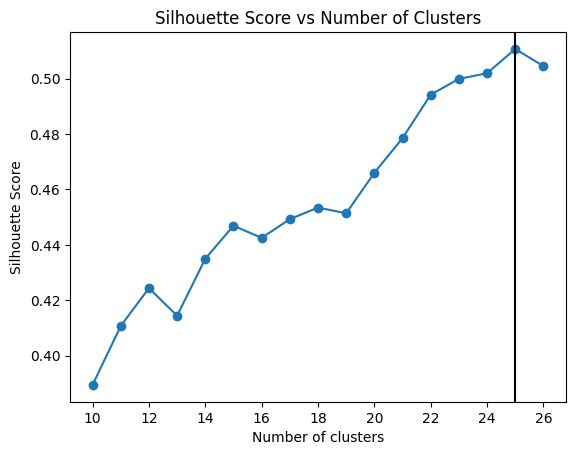

In [39]:
plt.plot(n_clusters, scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.axvline(best_clustering_model.n_clusters_,color='black')
plt.show()

In [47]:
cluster_labels = ["skills_group_" + str(label) 
                 for label in best_clustering_model.labels_]

In [49]:
fig = px.scatter(x=reduced_data.iloc[:, 0],
                 y=reduced_data.iloc[:, 1],
                 text=reduced_data.index.to_list(),
                 color = cluster_labels)
fig.update_traces(textposition='top center')
fig.update_layout(height=800, width=800, title_text='Cluster')
fig.show()

In [61]:
skills_clusters = reduced_data.index.to_series().groupby(cluster_labels).apply(list)
skills_clusters

skills_group_0     [DynamoDB, Elasticsearch, PostgreSQL, Redis, A...
skills_group_1     [Keras, NumPy, Pandas, TensorFlow, Python, IPy...
skills_group_10    [Firebase, Google Cloud Platform, Flutter, Dar...
skills_group_11    [Microsoft SQL Server, Microsoft Azure, .NET C...
skills_group_12                       [Assembly, Bash/Shell, C, C++]
skills_group_13                             [Java, Spring, IntelliJ]
skills_group_14                                         [R, RStudio]
skills_group_15      [Git, HTML/CSS, JavaScript, Visual Studio Code]
skills_group_16                    [SQLite, Xamarin, Django, Drupal]
skills_group_17                            [FastAPI, Flask, PyCharm]
skills_group_18                          [Objective-C, Swift, Xcode]
skills_group_19                    [TypeScript, Angular, Angular.js]
skills_group_2     [Cassandra, Couchbase, DigitalOcean, Heroku, Q...
skills_group_20                                [Ruby, Ruby on Rails]
skills_group_21                   

### Create Dataframe with clustered features

In [81]:
dfs = {}
for cluster, skills in skills_clusters.items():
    dfs[cluster] = skills_df.loc[:,skills].sum(axis=1)

In [93]:
clustered_skills_df = pd.concat([pd.DataFrame(dfs),df.loc[:,'DevType']],axis=1)

### Export DF

In [96]:
clustered_skills_df.to_pickle(CLUSTERED_DF_PATH)